# 0. Вспомогательные функции

In [34]:
def GetPerspective(img, FOV, THETA, PHI, height, width):

  equ_h = 512
  equ_w = 1024
  equ_cx = (equ_w - 1) / 2.0
  equ_cy = (equ_h - 1) / 2.0

  wFOV = FOV
  hFOV = float(height) / width * wFOV

  w_len = np.tan(np.radians(wFOV / 2.0))
  h_len = np.tan(np.radians(hFOV / 2.0))


  x_map = np.ones([height, width], np.float32)
  y_map = np.tile(np.linspace(-w_len, w_len,width), [height,1])
  z_map = -np.tile(np.linspace(-h_len, h_len,height), [width,1]).T

  D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
  xyz = np.stack((x_map,y_map,z_map),axis=2)/np.repeat(D[:, :, np.newaxis], 3, axis=2)

  y_axis = np.array([0.0, 1.0, 0.0], np.float32)
  z_axis = np.array([0.0, 0.0, 1.0], np.float32)
  [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
  [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

  xyz = xyz.reshape([height * width, 3]).T
  xyz = np.dot(R1, xyz)
  xyz = np.dot(R2, xyz).T
  lat = np.arcsin(xyz[:, 2])
  lon = np.arctan2(xyz[:, 1] , xyz[:, 0])

  lon = lon.reshape([height, width]) / np.pi * 180
  lat = -lat.reshape([height, width]) / np.pi * 180

  lon = lon / 180 * equ_cx + equ_cx
  lat = lat / 90  * equ_cy + equ_cy

  persp = cv2.remap(img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
  return persp

In [35]:
def get_actual_size(ims, width, height):
  temp = cv2.cvtColor(ims, cv2.COLOR_BGR2GRAY)
  contours, _ = cv2.findContours(temp, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  largest_contour = contours[0]
  x, y, w, h = cv2.boundingRect(largest_contour)

  cr = ims[y:y+h, x:x+w]
  dsize = ((int)(width / 5), (int)(height / 5))
  output = cv2.resize(cr, dsize)

  return output

# 1. Подключаем гугл диск и загружаем данные

In [36]:
# подключаем свой гугл диск к колабу
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt


depth_map = np.load('/content/drive/MyDrive/3D_train/data/depth_map.npy') # 512 * 1024
h_corners = np.load('/content/drive/MyDrive/3D_train/data/h_corners.npy') # 2 * 1024
v_corners = np.load('/content/drive/MyDrive/3D_train/data/v_corners.npy') # 12 * 2

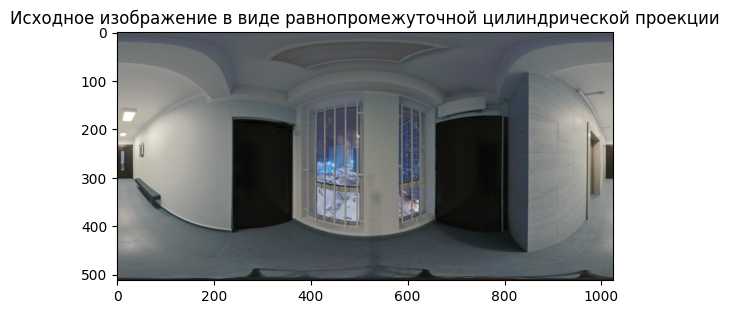

In [38]:
img = cv2.imread('/content/drive/MyDrive/3D_train/data/image_1024_aligned_rgb.png')
plt.imshow(img)
plt.title("Исходное изображение в виде равнопромежуточной цилиндрической проекции")
plt.show()


# 2. Перевод из цилиндрической в плоскую проекцию
использовал следующие шаги:
1. выделение каждого элемента путем создания маски
2. перевод элемента из цилиндрической в 2D проекцию
3. Масштабирование изображение (1 пиксель - 5 см)

## 2.1 стена №5
Длина - 6020

Высота - 2500

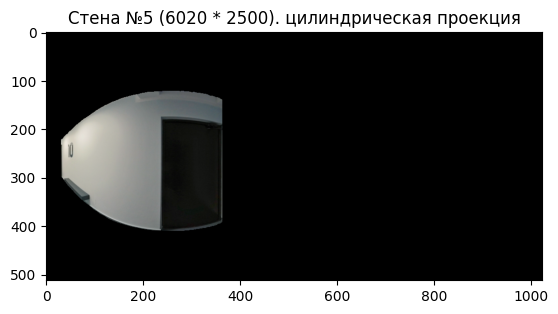

In [40]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[0][0]
right = v_corners[2][0]

for y in range(512):
  for x in range(1024):
    if (x > left and x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_5 = cv2.bitwise_and(img,img,mask=mask)
plt.title("Стена №5 (6020 * 2500). цилиндрическая проекция")
plt.imshow(wall_5)
plt.show()

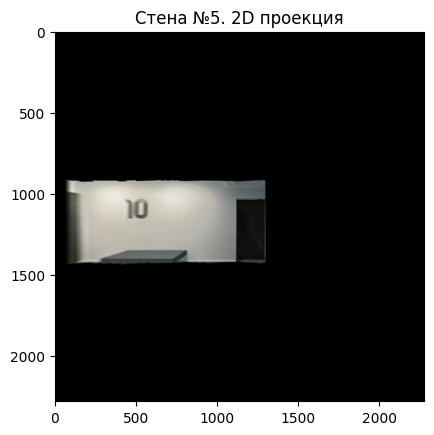

In [41]:
wall_5 = GetPerspective(wall_5, 160, -90,0,2280,2280)
plt.imshow(wall_5)
plt.title("Стена №5. 2D проекция")
plt.show()

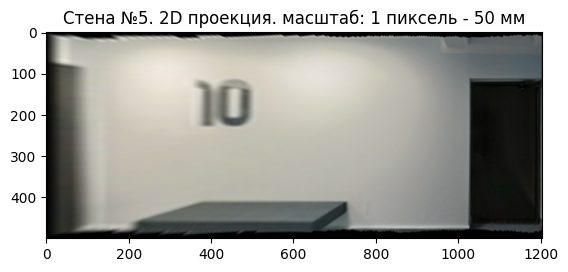

In [42]:
wall_5 = get_actual_size(wall_5, 6020, 2500)
plt.imshow(wall_5)
plt.title("Стена №5. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.2 стена №0
Длина - 2050

Высота - 2500

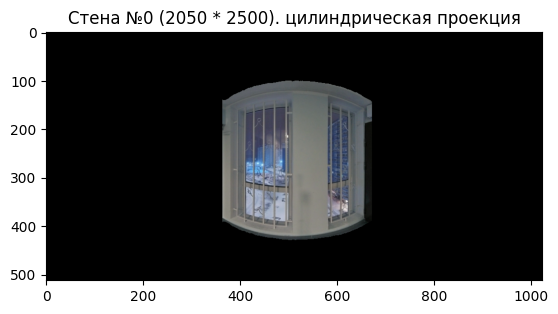

In [43]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[2][0]
right = v_corners[4][0]

for y in range(512):
  for x in range(1024):
    if (x > left and x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_0 = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(wall_0)
plt.title("Стена №0 (2050 * 2500). цилиндрическая проекция")
plt.show()

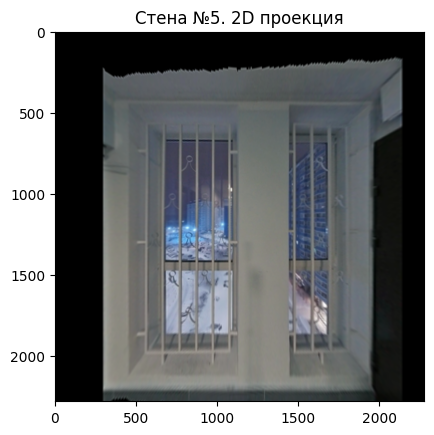

In [44]:
wall_0 = GetPerspective(wall_0, 120, 0,0,2280,2280)
plt.imshow(wall_0)
plt.title("Стена №5. 2D проекция")
plt.show()

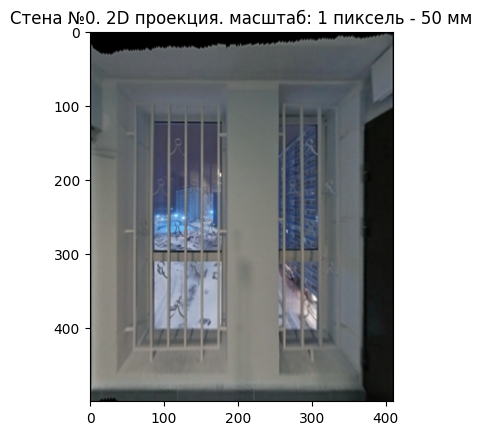

In [45]:
wall_0 = get_actual_size(wall_0, 2050, 2500)
plt.imshow(wall_0)
plt.title("Стена №0. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.3 стена №1
Длина - 1640

Высота - 2500

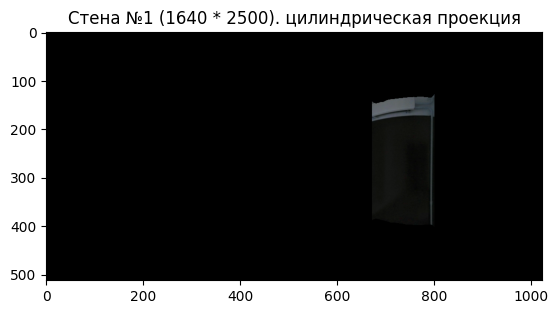

In [47]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[4][0]
right = v_corners[6][0]

for y in range(512):
  for x in range(1024):
    if (x > left and x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_1 = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(wall_1)
plt.title("Стена №1 (1640 * 2500). цилиндрическая проекция")
plt.show()

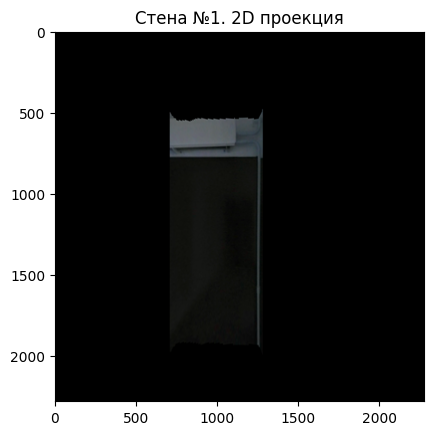

In [48]:
wall_1 = GetPerspective(wall_1, 120, 90,0,2280,2280)
plt.imshow(wall_1)
plt.title("Стена №1. 2D проекция")
plt.show()

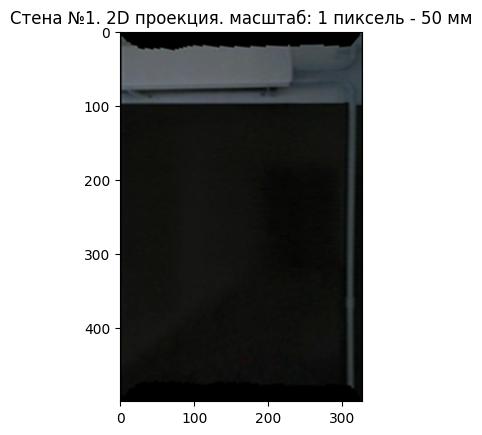

In [49]:
wall_1 = get_actual_size(wall_1, 1640, 2500)
plt.imshow(wall_1)
plt.title("Стена №1. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.4 стена №2
Длина - 400

Высота - 2500

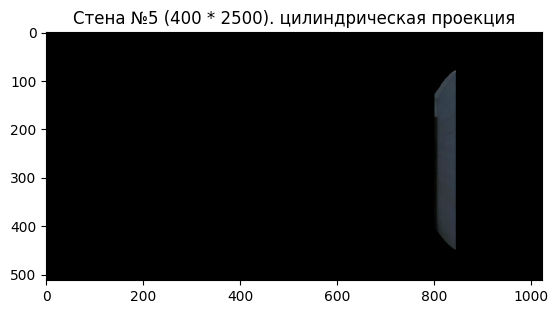

In [50]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[6][0]
right = v_corners[8][0]

for y in range(512):
  for x in range(1024):
    if (x > left and x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_2 = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(wall_2)
plt.title("Стена №5 (400 * 2500). цилиндрическая проекция")
plt.show()

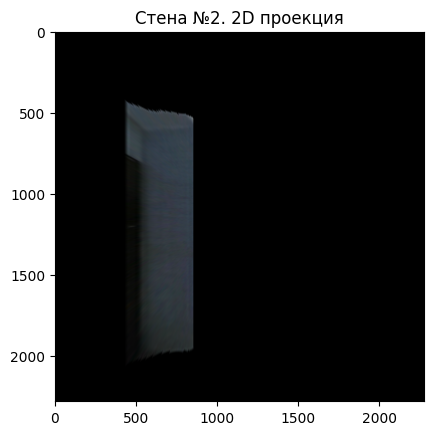

In [51]:
wall_2 = GetPerspective(wall_2, 165, 180,0,2280,2280)
plt.imshow(wall_2)
plt.title("Стена №2. 2D проекция")
plt.show()

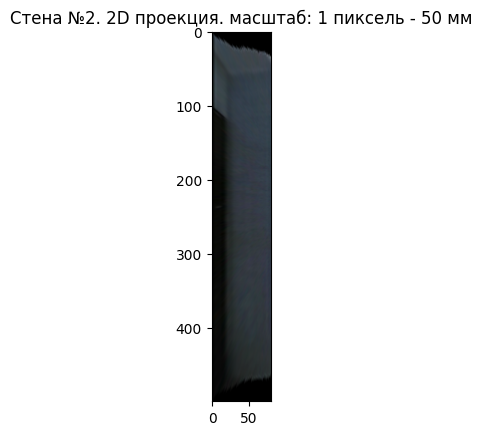

In [52]:
wall_2 = get_actual_size(wall_2, 400, 2500)
plt.imshow(wall_2)
plt.title("Стена №2. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.1 стена №3
Длина - 4380

Высота - 2500

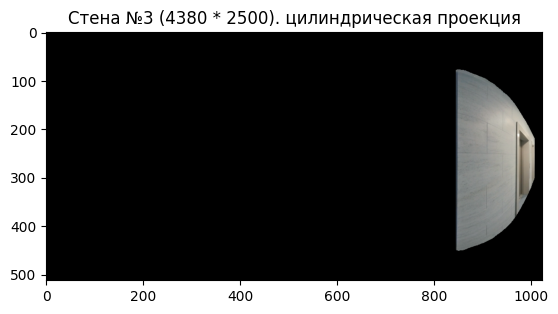

In [53]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[8][0]
right = v_corners[10][0]

for y in range(512):
  for x in range(1024):
    if (x > left and x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_3 = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(wall_3)
plt.title("Стена №3 (4380 * 2500). цилиндрическая проекция")
plt.show()

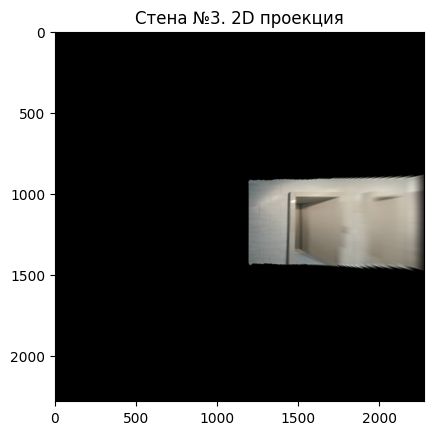

In [54]:
wall_3 = GetPerspective(wall_3, 170, 90,0,2280,2280)
plt.imshow(wall_3)
plt.title("Стена №3. 2D проекция")
plt.show()

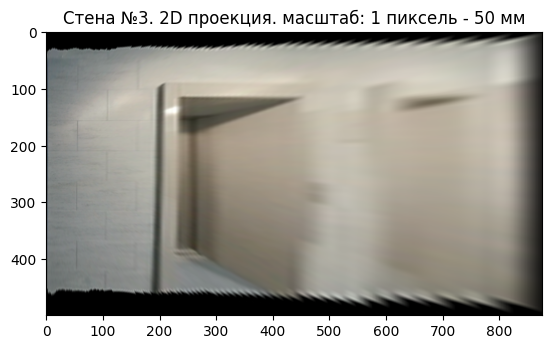

In [55]:
wall_3 = get_actual_size(wall_3, 4380, 2500)
plt.imshow(wall_3)
plt.title("Стена №3. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

# 2.6 Стена №4
Длина - 1650

Высота - 2500

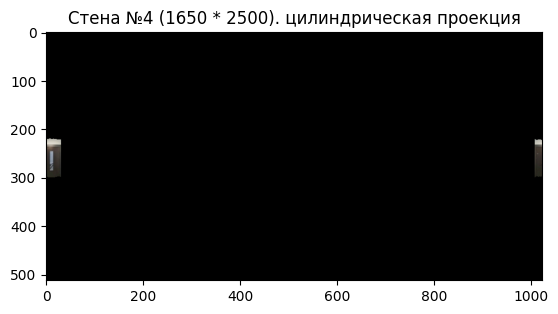

In [56]:
mask = np.zeros(img.shape[:2], dtype="uint8")
left = v_corners[10][0]
right = v_corners[0][0]

for y in range(512):
  for x in range(1024):
    if (x > left or x < right) and (y > h_corners[0][x] and y < h_corners[1][x]):
      mask[y][x] = 255

wall_4 = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(wall_4)
plt.title("Стена №4 (1650 * 2500). цилиндрическая проекция")
plt.show()

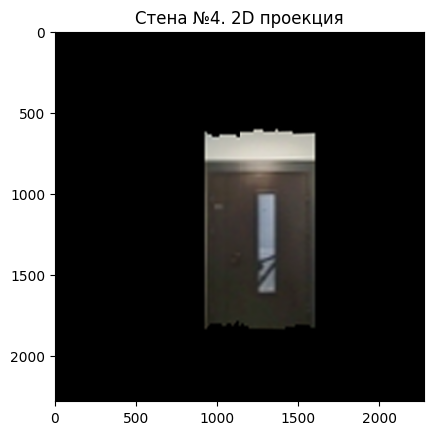

In [57]:
wall_4 = GetPerspective(wall_4, 50, 180,0,2280,2280)
plt.imshow(wall_4)
plt.title("Стена №4. 2D проекция")
plt.show()

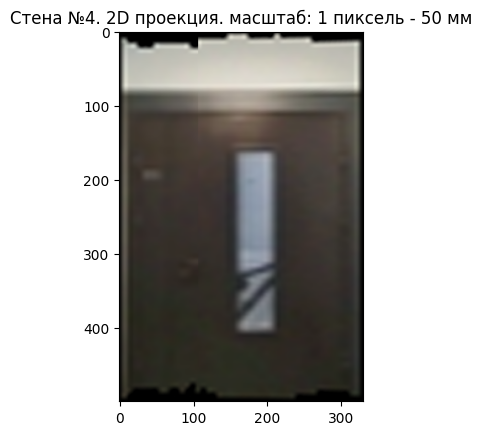

In [58]:
wall_4 = get_actual_size(wall_4, 1650, 2500)
plt.imshow(wall_4)
plt.title("Стена №4. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.1 Потолок
длина - 6020

ширина - 2050/1650

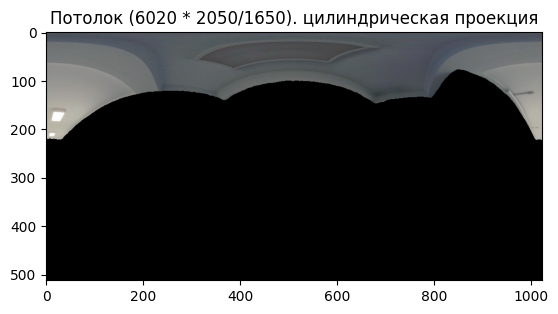

In [59]:
mask = np.zeros(img.shape[:2], dtype="uint8")

for y in range(512):
  for x in range(1024):
    if y < h_corners[0][x]:
      mask[y][x] = 255

ceil = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(ceil)
plt.title("Потолок (6020 * 2050/1650). цилиндрическая проекция")
plt.show()

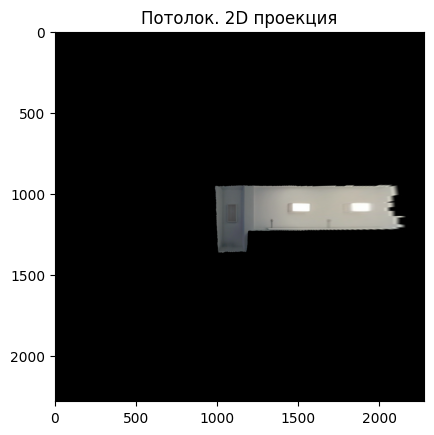

In [60]:
ceil = GetPerspective(ceil, 160, 90,90,2280,2280)
plt.imshow(ceil)
plt.title("Потолок. 2D проекция")
plt.show()

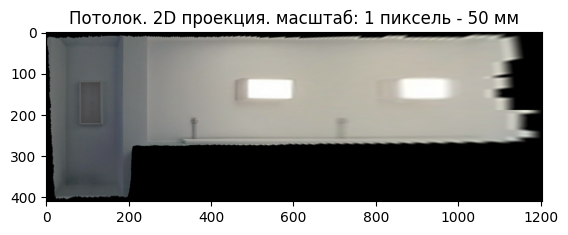

In [61]:
ceil = get_actual_size(ceil, 6020, 2050)
plt.imshow(ceil)
plt.title("Потолок. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

## 2.1 Пол
длина - 6020

ширина - 2050/1650

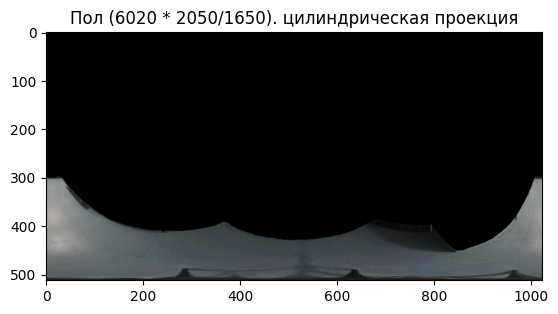

In [62]:
mask = np.zeros(img.shape[:2], dtype="uint8")

for y in range(512):
  for x in range(1024):
    if y > h_corners[1][x]:
      mask[y][x] = 255

floor = cv2.bitwise_and(img,img,mask=mask)
plt.imshow(floor)
plt.title("Пол (6020 * 2050/1650). цилиндрическая проекция")
plt.show()

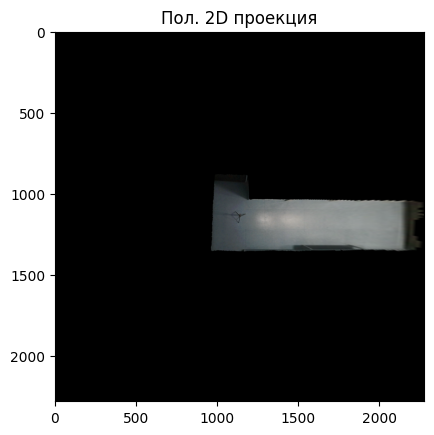

In [63]:
floor = GetPerspective(floor, 150, 90,-90,2280,2280)
plt.imshow(floor)
plt.title("Пол. 2D проекция")
plt.show()

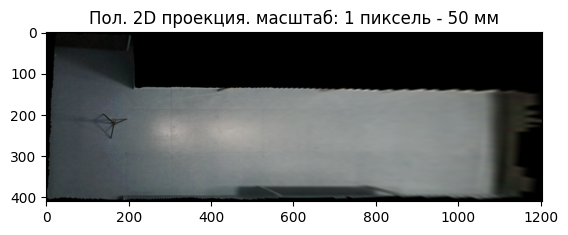

In [64]:
floor = get_actual_size(floor, 6020, 2050)
plt.imshow(floor)
plt.title("Пол. 2D проекция. масштаб: 1 пиксель - 50 мм")
plt.show()

# 3. Сохранение файлов

In [65]:
cv2.imwrite('/content/drive/MyDrive/3D_train/output/ceil_proj.jpg', ceil)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/floor_proj.jpg', floor)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/0_proj.jpg', wall_0)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/1_proj.jpg', wall_1)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/2_proj.jpg', wall_2)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/3_proj.jpg', wall_3)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/4_proj.jpg', wall_4)
cv2.imwrite('/content/drive/MyDrive/3D_train/output/5_proj.jpg', wall_5)

True